<a href="https://colab.research.google.com/github/kmjohnson3/Intro-to-MRI/blob/master/NoteBooks/Simulated_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Spatial Encoding

This Jupyter notebook provides some hands on experience with designing a 2D sampling experiment.

# Objectives
*   Understand the effect of changing readout parameters on images  
*   Investigate tradeoffs between choices of readout parameters. 

In python you need to load libraries to use them. This first cell imports a couple of key libraries to reconstruct images.

In [ ]:
# This is comment, Python will ignore this line

# Import libraries (load libraries which provide some functions)
%matplotlib inline
import numpy as np # array library
import math
import cmath
import pickle
import scipy.special 

# For interactive plotting
from ipywidgets import interact, interactive, FloatSlider, IntSlider
from IPython.display import clear_output, display, HTML

# for plotting modified style for better visualization
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# Sampling Data
We are going to makeup k-space data using an analytical phantom. The phantom consists of an exterior ring made of Fat with a chemical shift of 440 Hz (e.g. 3T main field), and an interior water compartment with some resolution objects. This cell defines the function and creates a ground truth image for reference. 

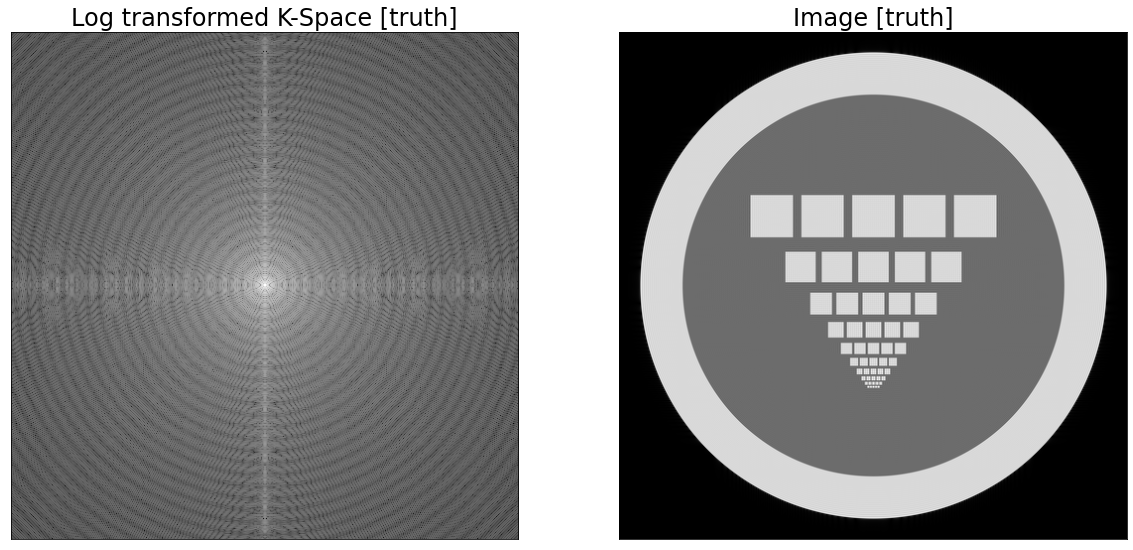

In [ ]:
def k_shift(k, kx, ky,x_shift, y_shift):
  '''
    Shift a k-space signal by adding linear phase
  '''
  return k*np.exp(2j*math.pi*ky*y_shift)*np.exp(2j*math.pi*kx*x_shift)

def k_square( kx, ky, x_shift, y_shift, w):
  '''
    Fourier transform of a square is sinc(kx)*sinc(ky)
  '''
  k =np.sinc(kx*w)*np.sinc(ky*w)*w*w
  return( k_shift(k, kx,ky,x_shift, y_shift))

def k_circle( kx, ky, x_shift, y_shift, w):
  '''
    Fourier transform of a circle is bessel function
  '''
  kr = w*np.sqrt(kx**2 + ky**2) 
  k = scipy.special.jv(1., kr * 2.0 * math.pi ) / (1e-6 + kr) * w**2
  return( k_shift(k, kx,ky,x_shift, y_shift))

def bullseye_phantom( kx, ky, kt=None):
  '''
    Function to create a bullseye phantom

    Input:
      kx:   k-space coordinates in kx [1/m]
      ky:   k-space coordinates in ky [1/m]
      kt:   time of each sample [s]
    Output:
      k_total:  complex k-space at kx,ky,t
  '''
  # Central water
  k_water = np.zeros_like( kx, dtype=np.complex64)
  k_water += k_circle(kx, ky, 0.0, 0.0, 90e-3)
  
  # Some small squares
  widths = np.geomspace(1e-3,20e-3,10)
  shifts = 1.2*(np.cumsum(widths) - 0.6*np.sum(widths))
  for position_y, w in zip(shifts, widths): 
    stride = 1.2*w
    for position_x in [-2,-1,0,1,2]:
      k_water += k_square(kx, ky, stride*position_x, position_y, w)
  
  # Outer fat
  k_fat =  k_circle(kx, ky, 0.0, 0.0, 110e-3) - k_circle(kx, ky, 0.0, 0.0, 90e-3)

  if kt is not None:
    k_fat *= np.exp(2j*math.pi*440*kt)

  k_total = k_water + 2*k_fat

  return k_total


# Defined size for phantom
FOV = 0.240 # m
dK = 1/FOV # m^-1
N = 512
kmax = N/2*dK

# Evaluate k-space
[kx, ky] = np.meshgrid( np.linspace(-kmax,kmax,N, dtype=np.float32),  np.linspace(-kmax,kmax,N, dtype=np.float32))
k = bullseye_phantom(kx,ky)

# Reconstruct with FFT
image = np.fft.fftshift(np.fft.ifft2(k))

# Plot 
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(np.log(np.abs(k)), cmap='gray')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Log transformed K-Space [truth]')
plt.subplot(122)
plt.imshow(np.abs(image), cmap='gray')
plt.title('Image [truth]')
plt.xticks([], [])
plt.yticks([], [])
plt.show()



# Creating a 2D sampling

This sets up a sampling experiment very similar to how a scanner would. There are two system constraints in the code whcih we haven't discussed:
* $G_{max}$ the maximum gradient strength. Typically 20-80 mT/m
* $slew$ $rate$ the maximum rate the gradient can change, typically 80-200 T/m/s 

These are hardcoded below to $50 mT/m$ and $100 T/m/s$ but feel free to change them to see their influence. They are below:
```
  gmax_system = 50e-3 # mT/m
  slew_system = 100 # T/m/s
```

## Readout Parameters 
There are a couple of ways to define sampling but we will define  based on:
* $BW [Hz]$ : the is effectively the strength of the frequency encoding gradient. We are using the definition $BW=\gamma G_{freq} FOV$ where $FOV$ is the defined field-of-view in x. This $FOV$ is just a convention but will define the size of the reconstructed image in the frequency encoding direction.
* $k_{max} [1/m]$ in x and y. The is the maximum area of the gradient. 
* $\Delta k_y $ the spacing of phase encodes. This also sets the number of phase encodes $ N_{pe} = \frac{2 k_{max} }{ \Delta k_y } $

## Experiments to try:
* Change the $BW$, what happens to the sampling time and gradient strength? When might you use a high $BW$ vs. a low $BW$ ?
* What parameters change the echo time? 
* Which parameters have the largest effect on scan time?
* Why do we not have a $\Delta k_x $?


In [ ]:
def build_prephaser( area, slew, gmax, dT):
  """
    Function to estimate gradient based on area.

    Input:
      area  - area of gradient in s*T/m
      slew  - slew rate of system in T/m/s
      gmax  - maximum gradient strength of system
      dT    - resolution of gradient system
   
    Output:
      g_trap - the gradient in T/m in the resolution of the system
  """

  # This will help with some of the math
  t_rise = (gmax/slew)
  area_min_trap = t_rise * gmax

  if np.abs(area) < area_min_trap:
    # Triangle shaped gradient
    pwa = np.sqrt( np.abs(area) / slew )
    pw = 0 
  else:
    # Trapezoid shaped gradient
    pwa = t_rise
    pw = (np.abs(area) - area_min_trap ) / gmax

  # Round to system resolution
  n_pw = int(np.round(pw/dT))
  n_pwa = int(np.round(pwa/dT))

  # Add the attack, flattop, decay
  g_trap = np.concatenate((np.linspace(0,1,n_pwa), np.ones((n_pw,)), np.linspace(1,0,n_pwa)))
  g_trap = g_trap * area / (dT*np.sum(g_trap))

  return g_trap

def build_readout(BW, FOV, kmax, slew, gmax, dT, gamma=42.58e6):
  """
    Function to estimate gradient for a readout

    Input:
      BW    - Bandwidth of readout in Hz
      FOV   - Field of view in m
      kmax  - Maximum extent in k-space in 1/m
      slew  - slew rate of system in T/m/s
      gmax  - maximum gradient strength of system
      dT    - resolution of gradient system
   
    Output:
      g_trap - the gradient in T/m in the resolution of the system
      pre_phase_area - the area required to phase the gradients
      idx - index array for readout
  """

  # BW is in +/- Hz over the FOV (solve BW = gamma*G*FOV)
  amp_freq = BW / (gamma*FOV)
  
  # Get the central area where we sample
  area = 2.0*kmax / gamma
  Tread = area / amp_freq
  n_pw = int(np.round(Tread/dT))

  # Get Prephase
  Tramp = amp_freq / slew
  n_pwa = int(np.round(Tramp/dT))

  g_trap = np.concatenate((np.linspace(0,1,n_pwa), np.ones((n_pw,)), np.linspace(1,0,n_pwa)))
  g_trap *= amp_freq

  idx = np.concatenate((np.zeros(n_pwa,), np.ones((n_pw,)), np.zeros(n_pwa,)))
  idx = idx == 1

  pre_phase_area = -0.5*Tramp*amp_freq - 0.5*Tread*amp_freq
    
  return g_trap, pre_phase_area, idx

def calc_2d_gradients( BW, kmax_x, kmax_y):
  """
    Function to estimate gradient for a readout with phase encoding

    Input:
      BW     - Bandwidth of readout in Hz
      kmax_x - Maximum extent in x [1/m]
      kmax_y - Maximum extent in y [1/m]
    Output:
      gx, gy - the gradient in mT/m in the resolution of the system
  """

  # System paramaters (fixed in this simulation)
  FOV = 0.24 # m 
  gmax_system = 50e-3 # mT/m
  slew_system = 100 # T/m/s
  gamma = 42.58e6
  dT_system = 4e-6

  # Build the gradients. This uses system limits
  gx_read, pre_phase_area, idx = build_readout(BW=BW,FOV=FOV, kmax=kmax_x, slew=slew_system, gmax=gmax_system, dT=dT_system)
  gx_pre = build_prephaser( pre_phase_area, slew=slew_system, gmax=gmax_system, dT=dT_system)
  gy_pre = build_prephaser( kmax_y / gamma, slew=slew_system, gmax=gmax_system, dT=dT_system)
  
  # Pad prephaser so that the pulses are the same length
  if len(gx_pre) > len(gy_pre):
    # Pad gy with zeros
    gy_pre = np.pad(gy_pre,(0,len(gx_pre)-len(gy_pre)))
  elif len(gx_pre) < len(gy_pre):
    # Pad x=gx with zeros
    gx_pre = np.pad(gx_pre,(len(gy_pre)-len(gx_pre),0))

  gx = np.concatenate((gx_pre,gx_read))
  gy = np.concatenate((gy_pre,0*gx_read))

  idx = np.concatenate((np.zeros((len(gx_pre,))), idx))
  idx = idx == 1.0

  # Convert to k-space
  kx = gamma*np.cumsum(gx)*dT_system
  ky = gamma*np.cumsum(gy)*dT_system
  kt = dT_system*np.arange(len(kx))

  return gx, gy, kx, ky, kt, idx

def plot_gradient( BW, kmax_x, kmax_y, dk_y):
  
  # Calculate the gradients for the largest phase encode
  gx, gy, kx, ky, kt, idx = calc_2d_gradients( BW, kmax_x, kmax_y)
  
  # Scale gy for
  Npe = int( (2*kmax_y / dk_y) + 1)
  ky_scale = np.linspace(-1,1,Npe)

  plt.figure(figsize=(8,8))

  # Plot Gx
  plt.subplot(221)
  plt.plot(1e3*kt,1e3*gx)
  plt.ylabel('$G_x$ [mT/m]')
  plt.xlabel('$Time$ [us]')
  plt.ylim([-50, 50])

  # Plot Gy
  plt.subplot(223)
  for scale in ky_scale:
    plt.plot(1e3*kt,1e3*gy*scale)
  plt.ylabel('$G_y$ [mT/m]')
  plt.xlabel('$Time$ [ms]')
  plt.ylim([-50, 50])

  # Plot Kx
  plt.subplot(222)
  plt.plot(1e3*kt,kx/1e3)
  plt.ylabel('$K_x$ [1/mm]')
  plt.xlabel('$Time$ [ms]')

  # Plot Ky
  plt.subplot(224)
  for scale in ky_scale:
    plt.plot(1e3*kt,ky*scale/1e3)
  plt.ylabel('$K_y$ [1/mm]')
  plt.xlabel('$Time$ [ms]')

  plt.tight_layout(pad=2)
  plt.show()
  

w = interactive(plot_gradient, 
                BW=FloatSlider(min=62.5e3, max=250e3, value=125e3, description='BW [Hz]', continuous_update=False),
                kmax_x=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax x [1/m]', continuous_update=False),
                kmax_y=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax y [1/m]', continuous_update=False),
                dk_y=FloatSlider(min=1/240e-3, max=1/10e-3, value=1/10e-3, description='dky [1/m]', continuous_update=False))
                     
display(w)

interactive(children=(FloatSlider(value=125000.0, continuous_update=False, description='BW [Hz]', max=250000.0…

# Imaging Experiment

This will simulate and plot images for the given phantom and parameters. You can alway reset the parameters by rerunning the cell. Some of the parameters will cause the cell to run for several seconds before it updates. Some experiments to try:

1.   Starting with the default parameters, change the BW higher and lower. What are the effects and which bandwidth would you choose based on this experiment?
2.   Repeat 1 but with higher noise levels. Does this change your answer to 1?
3.   Increase the $\Delta k_y$. Do the artifacts look as you would expect?
4.   With no noise, change the $k_{max}$. Are there artifacts aside from the resolution differences? 
5.   Repeat 4 with noise.
6.   With high noise levels, increase the number of averages. What is the effect?



In [ ]:
def get_kspace_coordinates( BW, kmax_x, kmax_y, dk_y):
  """
    Function to get k-space coordinates

    Input:
      BW:     - Bandwidth of readout in Hz
      kmax_x: - Maximum extent in x [1/m]
      kmax_y: - Maximum extent in y [1/m]
      dk_y:   - The spacing of ky phase encodes [1/m]
    Output:
      kx:     - kx coordinates [1/m]
      ky:     - kt coordinates [1/m]
      kt:     - kt sampling time of each point in kspace
      
  """

  # Calculate the gradients for the largest phase encode
  gx, gy, kx, ky, kt, idx = calc_2d_gradients( BW, kmax_x, kmax_y)
  
  # Scale gy for each phase encode
  Npe = int( (2*kmax_y / dk_y) + 1)
  ky_scale = np.linspace(-1,1,Npe)

  # gather kx,ky for all the phase encodes
  kx_2 = []
  ky_2 = []
  kt_2 = []
  for scale in ky_scale:
    kx_2.append(kx[idx])
    ky_2.append(scale*ky[idx])
    kt_2.append(kt[idx])
  kx = np.stack(kx_2,axis=0)
  ky = np.stack(ky_2,axis=0)
  kt = np.stack(kt_2,axis=0)

  return kx, ky, kt

def sim_and_plot( BW=250e3, kmax_x=1/10e-3, kmax_y=1/10e-3, dk_y=1/240e-3, noise=0, averages=1):

  # Get y
  kx, ky, kt = get_kspace_coordinates( BW=BW, kmax_x=kmax_x, kmax_y=kmax_y, dk_y=dk_y)

  # Get kspace values
  k0 = bullseye_phantom(0,0)

  # Add noise
  kspace = averages*bullseye_phantom(kx, ky, kt)
  for a in range(averages):
    kspace += k0*noise*(np.random.standard_normal(kspace.shape) + 1j*np.random.standard_normal(kspace.shape))

  # Reconstruct with Fourier transform
  image = np.fft.fftshift(np.fft.ifft2(kspace))

  # For plotting the image size will change based on BW. Adjust to suite
  BW_system = 1 / (kt[0,1] - kt[0,0])
  aspect = BW_system / BW
  crop = np.abs(np.linspace(-aspect, aspect, image.shape[1])) < 1.0

  # Also adjust y fov to match reconstructed size
  aspect_y = 1/240e-3  / dk_y

  print(f'Minimum scan time = {np.max(kt)*ky.shape[0]*averages}, Echo time = {1e3*np.mean(kt)} ms')

  plt.figure(figsize=(10,10))
  plt.imshow(np.abs(image[:,crop]),aspect=aspect_y,cmap='gray')
  plt.xticks([], [])
  plt.yticks([], [])
  plt.show()

w = interactive(sim_and_plot, 
                BW=FloatSlider(min=62.5e3, max=250e3, value=125e3, description='BW [Hz]', continuous_update=False),
                kmax_x=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax x [1/m]', continuous_update=False),
                kmax_y=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax y [1/m]', continuous_update=False),
                dk_y=FloatSlider(min=1/240e-3, max=1/80e-3, value=1/480e-3, step=1/480e-3, description='dky [1/m]', continuous_update=False),
                noise=FloatSlider(min=0, max=0.1, value=0, step=1e-6, description='noise level', continuous_update=False),
                averages=IntSlider(min=1, max=4, value=1, description='averages', continuous_update=False))
                                                        
display(w)

interactive(children=(FloatSlider(value=125000.0, continuous_update=False, description='BW [Hz]', max=250000.0…